In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from contrastive_model import SemanticSimilarityModel
from zero_shot_datasets import GTZANDataset
from transformers import  BertTokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import glob
import os
import IPython

In [2]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
model = SemanticSimilarityModel().to(device)
saved_model = torch.load('contrasitive_training_checkpoints/checkpoint_epoch_100.pth')
state_dict = saved_model['model_state_dict']
training_loss = saved_model['train_loss']
validation_loss = saved_model['valid_loss']

print(f'training loss: {training_loss} \nvalidation los: {validation_loss}')
model.load_state_dict(state_dict)
model.eval()

/home/theodore/Desktop/regularized music encoder/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


training loss: 4.93751827029288 
validation los: 5.057297009688157


SemanticSimilarityModel(
  (music_encoder): TransformerVQVAE(
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=

In [5]:
def text_embedding(text):
    inputs = bert_tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

    input_ids = inputs['input_ids'].squeeze(0)
    attention_mask = inputs['attention_mask'].squeeze(0)

    return input_ids, attention_mask

In [6]:
from zero_shot_utils import get_melspec

def predict_similarity(music_path, text):
    music = get_melspec(music_path)

    inputs = bert_tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

    input_ids = inputs['input_ids'].squeeze(0)
    attention_mask = inputs['attention_mask'].squeeze(0)

    music = music.unsqueeze(0)
    music = music.unsqueeze(2)
    input_ids = input_ids.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)

    music, input_ids, attention_mask = music.to(device), input_ids.to(device), attention_mask.to(device)

    music_embedding, text_embedding = model(music, input_ids, attention_mask)
    
    similarity = F.cosine_similarity(music_embedding.unsqueeze(1), text_embedding.unsqueeze(0), dim=2)

    return similarity

In [7]:
'''MUSIC INSTRUMENT DETECTION'''
labels = ['Piano', 'Drums', 'Acoustic Guitar', 'String Ensemble']
gtruth = ['piano', 'drums', 'guitar', 'strings']



def predict_instrument(music_path):
    assert os.path.isfile(music_path)
    similarities = []
    for text in labels:
        sim_score = predict_similarity(music_path, text)
        similarities.append(sim_score.detach().cpu().numpy())
    max_arg = np.argmax(similarities)
    return gtruth[max_arg]
    # for i in range(len(similarities)):
    #     print(f'{labels[i]}: {similarities[i][0][0]}')

preds = []
actual = []
for idx in range(len(gtruth)):
    for i in tqdm(range(1, 31), desc='predicting...'):
        prediction =  predict_instrument(f'../../data/instruments/{gtruth[idx]}_{i}.wav')
        preds.append(prediction)
        actual.append(gtruth[idx])




predicting...: 100%|██████████| 30/30 [00:07<00:00,  4.17it/s]


Confusion Matrix:


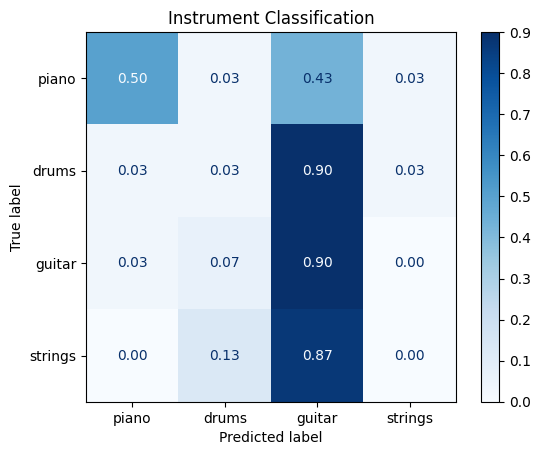

In [8]:
# Generate confusion matrix
cm = confusion_matrix(actual, preds)
cm = cm/cm.sum(axis=1)
cm = np.around(cm, decimals=2)
# Print confusion matrix
cm = np.around(cm, decimals=2)

# Print formatted confusion matrix
print("Confusion Matrix:")

# Normalize the confusion matrix
cm = confusion_matrix(actual, preds)
cm = cm / cm.sum(axis=1, keepdims=True)

# Format the confusion matrix to two decimal places
cm = np.around(cm, decimals=2)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gtruth)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title('Instrument Classification')
plt.show()


In [9]:
# F1 score calculation
print(cm)
precision = []
recall = []
f1_scores = []

# Compute metrics for each class
num_classes = cm.shape[0]
for i in range(num_classes):
    TP = cm[i, i]
    FP = sum(cm[:, i]) - TP
    FN = sum(cm[i, :]) - TP
    
    # Precision, Recall, and F1 for the class
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    
    precision.append(prec)
    recall.append(rec)
    f1_scores.append(f1)

# Macro-averaged F1 score
macro_f1 = np.mean(f1_scores)

# Print results
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1 scores per class: {f1_scores}")
print(f"Macro-averaged F1 score: {macro_f1}")

[[0.5  0.03 0.43 0.03]
 [0.03 0.03 0.9  0.03]
 [0.03 0.07 0.9  0.  ]
 [0.   0.13 0.87 0.  ]]
Precision per class: [0.8928571428571428, 0.11538461538461538, 0.2903225806451613, 0.0]
Recall per class: [0.5050505050505051, 0.030303030303030304, 0.9, 0.0]
F1 scores per class: [0.6451612903225806, 0.048, 0.4390243902439024, 0]
Macro-averaged F1 score: 0.28304642014162074


In [10]:
'''TEMPO CLASSIFICATION'''
tempos = ['fast', 'slow']
def predict_tempo(music_path):
    assert os.path.isfile(music_path)
    similarities = []
    for text in tempos:
        sim_score = predict_similarity(music_path, text)
        similarities.append(sim_score.detach().cpu().numpy())
    max_arg = np.argmax(similarities)
    return tempos[max_arg]

print(predict_tempo('../../data/tempo/fast_1.wav'))
print(predict_tempo('../../data/tempo/fast_2.wav'))
print(predict_tempo('../../data/tempo/fast_3.wav'))
print(predict_tempo('../../data/tempo/fast_4.wav'))
print(predict_tempo('../../data/tempo/fast_5.wav'))
print(predict_tempo('../../data/tempo/fast_6.wav'))
print(predict_tempo('../../data/tempo/fast_7.wav'))
print(predict_tempo('../../data/tempo/fast_8.wav'))
print(predict_tempo('../../data/tempo/fast_9.wav'))
print(predict_tempo('../../data/tempo/fast_10.wav'))
print('=' * 50)
print(predict_tempo('../../data/tempo/slow_1.wav'))
print(predict_tempo('../../data/tempo/slow_2.wav'))
print(predict_tempo('../../data/tempo/slow_3.wav'))
print(predict_tempo('../../data/tempo/slow_4.wav'))
print(predict_tempo('../../data/tempo/slow_5.wav'))
print(predict_tempo('../../data/tempo/slow_6.wav'))
print(predict_tempo('../../data/tempo/slow_7.wav'))
print(predict_tempo('../../data/tempo/slow_8.wav'))
print(predict_tempo('../../data/tempo/slow_9.wav'))
print(predict_tempo('../../data/tempo/slow_10.wav'))

slow
slow
slow
slow
slow
slow
slow
slow
slow
slow
slow
fast
slow
slow
fast
slow
slow
slow
slow
slow


In [43]:
import pandas as pd
midicaps_df = pd.read_csv('../../data/MIDICaps/captions.csv', header = None)
midicaps_df.rename(columns = {0: 'path', 1: 'captions'}, inplace = True)

In [44]:
midicaps_df.iloc[0]['captions']

'A short electronic ambient song featuring a piano, set in E major with a 4/4 time signature and a Presto tempo. The composition evokes a cinematic, energetic, and melodic atmosphere with hints of epic and dark undertones. The chord progression of B, Emaj7, C#m7, B7, and A adds to its captivating ambiance.'

In [11]:
'''TIME SIGNATURE CLASSIFICATION'''
import os 
import glob
keys = ['4/4', '3/4', '2/4']
def predict_key(music_path):
    assert os.path.isfile(music_path)
    similarities = []
    for text in keys:
        prompt = f'song in {text} time'
        sim_score = predict_similarity(music_path, prompt)
        similarities.append(sim_score.detach().cpu().numpy())
    max_arg = np.argmax(similarities)
    return keys[max_arg]

import IPython
filenames = glob.glob(os.path.join('../../data/time signature detection/', '*.wav'))
predictions = []
actual = []
for path in filenames:
    temp = path.split('/')[-1].split('_')[0]
    if temp  == '44':
        gtruth = '4/4'
    elif temp == '34':
        gtruth = '3/4'
    elif temp == '24':
        gtruth = '2/4'

    preds = predict_key(path)

    predictions.append(preds)
    actual.append(gtruth)

Confusion Matrix:


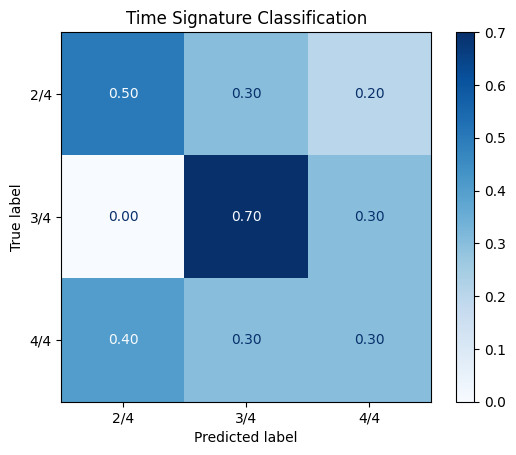

In [12]:
# Generate confusion matrix
cm = confusion_matrix(actual, predictions)
cm = cm/cm.sum(axis=1)
cm = np.around(cm, decimals=2)

# Print formatted confusion matrix
print("Confusion Matrix:")


# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=keys[::-1])
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title('Time Signature Classification')
plt.show()


In [13]:
# F1 score calculation
print(cm)
precision = []
recall = []
f1_scores = []

# Compute metrics for each class
num_classes = cm.shape[0]
for i in range(num_classes):
    TP = cm[i, i]
    FP = sum(cm[:, i]) - TP
    FN = sum(cm[i, :]) - TP
    
    # Precision, Recall, and F1 for the class
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    
    precision.append(prec)
    recall.append(rec)
    f1_scores.append(f1)

# Macro-averaged F1 score
macro_f1 = np.mean(f1_scores)

# Print results
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1 scores per class: {f1_scores}")
print(f"Macro-averaged F1 score: {macro_f1}")

[[0.5 0.3 0.2]
 [0.  0.7 0.3]
 [0.4 0.3 0.3]]
Precision per class: [0.5555555555555556, 0.5384615384615384, 0.37499999999999994]
Recall per class: [0.5, 0.7, 0.3]
F1 scores per class: [0.5263157894736842, 0.608695652173913, 0.3333333333333333]
Macro-averaged F1 score: 0.4894482583269768


Sentiment Analysis

In [52]:
'''KEY DETECTION'''
import os 
import glob
sentiments = [
    "C major", "G major", "D major"
]

def predict_key(music_path):
    assert os.path.isfile(music_path)
    similarities = []
    for text in sentiments:
        prompt = f'A song in the key of {text}'
        sim_score = predict_similarity(music_path, prompt)
        similarities.append(sim_score.detach().cpu().numpy())
    max_arg = np.argmax(similarities)
    return sentiments[max_arg]


filenames = glob.glob(os.path.join('../../data/chord detection/', '*.wav'))
print(filenames)
predictions =[]
for path in filenames:
    name = path.split('/')[-1]
    temp = name.split('_')[0]

    preds = predict_key(path)

    predictions.append([name, preds])

['../../data/chord detection/canon_d3.wav', '../../data/chord detection/canon_c2.wav', '../../data/chord detection/canon_d1.wav', '../../data/chord detection/canon_d5.wav', '../../data/chord detection/canon_d2.wav', '../../data/chord detection/canon_c_1.wav', '../../data/chord detection/canon_c3.wav', '../../data/chord detection/canon_d4.wav', '../../data/chord detection/canon_c4.wav']


In [ ]:
predictions = sorted(predictions, key=lambda x: x[0])
for path, sentiment in predictions:
    print(f'{path} \t {sentiment}')

canon_c2.wav 	 C major
canon_c3.wav 	 C major
canon_c4.wav 	 C major
canon_c_1.wav 	 C major
canon_d1.wav 	 G major
canon_d2.wav 	 D major
canon_d3.wav 	 D major
canon_d4.wav 	 C major
canon_d5.wav 	 C major


: 